<a href="https://colab.research.google.com/github/suyeonb/AI_lab_baesuyeon/blob/main/week12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.8.0+cu126


In [ ]:
# Load California Housing dataset
data = fetch_california_housing()

# Extract features and target
X = data.data
y = data.target

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {data.feature_names}")
print(f"Target: Median house value (in $100,000s)")

# Display statistics
print(f"\nTarget statistics:")
print(f"  Min: ${y.min() * 100000:.2f}")
print(f"  Max: ${y.max() * 100000:.2f}")
print(f"  Mean: ${y.mean() * 100000:.2f}")

Dataset Information:
Number of samples: 20640
Number of features: 8

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median house value (in $100,000s)

Target statistics:
  Min: $14999.00
  Max: $500001.00
  Mean: $206855.82


In [ ]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize features using StandardScaler
# This helps neural networks train faster and more stably
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data normalized (mean=0, std=1)")

Training set size: 16512 samples
Test set size: 4128 samples

✓ Data normalized (mean=0, std=1)


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Batch size: 64
Number of training batches: 258
Number of test batches: 65


In [ ]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(RegressionModel, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize model
input_size = X_train_scaled.shape[1]  # Number of features (8)
model = RegressionModel(input_size).to(device)

print(model)
print(f"\nModel moved to: {device}")

RegressionModel(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Model moved to: cuda


In [ ]:
# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# Optimizer: Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


In [ ]:
# Training parameters
num_epochs = 20

# Track losses for visualization
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1. Forward pass: compute predictions
        predictions = model(X_batch)

        # 2. Compute loss
        loss = criterion(predictions, y_batch)

        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients

        # 4. Update weights
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase (no gradient computation needed)
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

Starting training...
------------------------------------------------------------
Epoch [10/20] | Train Loss: 0.2344 | Test Loss: 0.2745
Epoch [20/20] | Train Loss: 0.2319 | Test Loss: 0.2719
------------------------------------------------------------
Training complete!


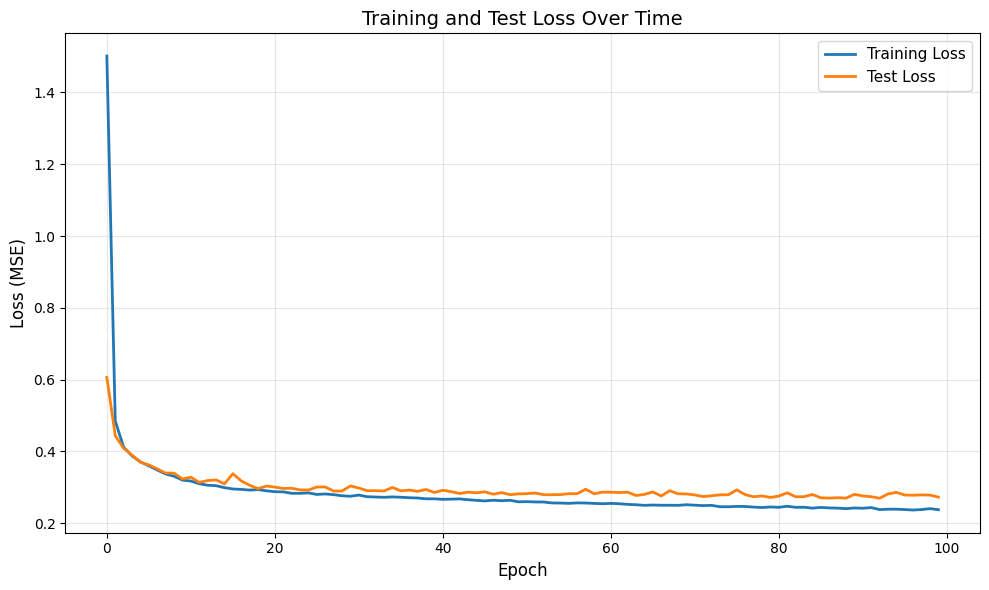

Final Training Loss: 0.2378
Final Test Loss: 0.2728


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

In [ ]:
# Make predictions on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print(f"\nInterpretation:")
print(f"On average, predictions are off by ${mae * 100000:.2f}")
print(f"Model explains {r2*100:.2f}% of the variance in house prices")

Model Performance on Test Set:
Mean Squared Error (MSE):  0.2733
Root Mean Squared Error (RMSE): 0.5227
Mean Absolute Error (MAE): 0.3569
R² Score: 0.7915

Interpretation:
On average, predictions are off by $35689.19
Model explains 79.15% of the variance in house prices


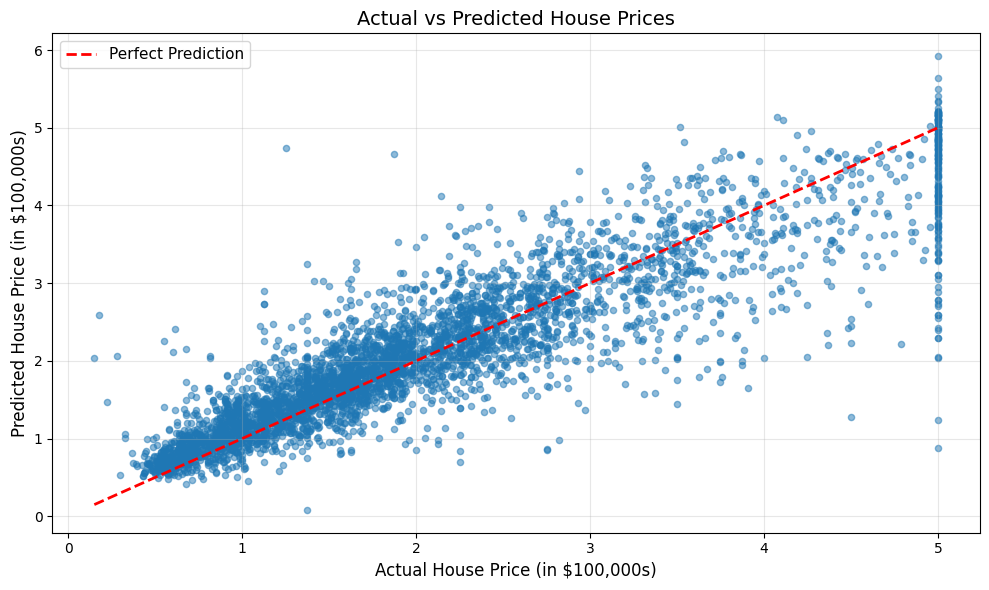


Sample Predictions (first 10 houses):
------------------------------------------------------------
      Actual |    Predicted |   Difference
------------------------------------------------------------
$    47,700 | $    58,942 | $   -11,242
$    45,800 | $    73,624 | $   -27,824
$   500,001 | $   460,492 | $    39,509
$   218,600 | $   245,022 | $   -26,422
$   278,000 | $   292,612 | $   -14,612
$   158,700 | $   171,338 | $   -12,638
$   198,200 | $   235,478 | $   -37,278
$   157,500 | $   175,265 | $   -17,765
$   340,000 | $   236,978 | $   103,022
$   446,600 | $   466,467 | $   -19,867


In [ ]:
# Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual House Price (in $100,000s)', fontsize=12)
plt.ylabel('Predicted House Price (in $100,000s)', fontsize=12)
plt.title('Actual vs Predicted House Prices', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some sample predictions
print("\nSample Predictions (first 10 houses):")
print("-" * 60)
print(f"{'Actual':>12} | {'Predicted':>12} | {'Difference':>12}")
print("-" * 60)
for i in range(min(10, len(y_true))):
    actual = y_true[i][0] * 100000
    predicted = y_pred[i][0] * 100000
    diff = actual - predicted
    print(f"${actual:>10,.0f} | ${predicted:>10,.0f} | ${diff:>10,.0f}")

In [ ]:
# Save model
torch.save(model.state_dict(), 'house_price_model.pth')
print("✓ Model saved to 'house_price_model.pth'")

# To load the model later:
# model = RegressionModel(input_size)
# model.load_state_dict(torch.load('house_price_model.pth'))
# model.to(device)
# model.eval()

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('house_price_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

✓ Model saved to 'house_price_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('house_price_model.pth'))
  model.to(device)
  model.eval()


In [2]:
# LAB - Regression : Gold Price 예측
# - Kaggle financial_regression.csv 사용
# - 목표(target): gold close
#   1) 데이터 로드 및 전처리
#   2) train / test 분할
#   3) 정규화
#   4) PyTorch 회귀 모델 학습
#   5) MSE / RMSE / MAE / R^2 출력

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 0. 기본 설정
# -----------------------------
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# 1. 데이터 로드
# -----------------------------
CSV_PATH = "financial_regression.csv"  # 같은 폴더에 두면 됨
df = pd.read_csv(CSV_PATH)

print("원본 데이터 shape:", df.shape)
print("컬럼 목록:", df.columns.tolist())

# 날짜는 문자열이라 회귀에 직접 쓰기 애매하므로 제거
if "date" in df.columns:
    df = df.drop(columns=["date"])

# 타깃: gold close (금 종가)
TARGET_COLUMN = "gold close"

# 타깃이 없는 행(휴장일 등)은 사용하지 않음
df = df.dropna(subset=[TARGET_COLUMN]).copy()

# 숫자형 컬럼만 사용
df = df.select_dtypes(include=[np.number])

# 남은 결측치는 각 열의 평균으로 채움 (간단한 전처리)
df = df.fillna(df.mean(numeric_only=True))

# 특징(X), 타깃(y) 분리
y = df[TARGET_COLUMN].values
X = df.drop(columns=[TARGET_COLUMN]).values

print("최종 사용 데이터 shape:", X.shape, "(samples, features)")
print("feature 개수:", X.shape[1])

# -----------------------------
# 2. train / test 분할
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 3. 정규화 (StandardScaler)
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4. Tensor 변환 + DataLoader
# -----------------------------
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

# -----------------------------
# 5. 회귀 모델 정의
# -----------------------------
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train_scaled.shape[1]
model = RegressionModel(input_size).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 150  # 에포크

# -----------------------------
# 6. 학습 루프
# -----------------------------
print("=== Training start ===")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # forward
        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f}")

print("=== Training done ===")

# -----------------------------
# 7. 테스트 성능 평가
# -----------------------------
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n=== Test 성능 (Gold Price Regression) ===")
print(f"MSE :  {mse:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAE :  {mae:.4f}")
print(f"R^2 :  {r2:.4f}")

Using device: cuda
원본 데이터 shape: (3904, 47)
컬럼 목록: ['date', 'sp500 open', 'sp500 high', 'sp500 low', 'sp500 close', 'sp500 volume', 'sp500 high-low', 'nasdaq open', 'nasdaq high', 'nasdaq low', 'nasdaq close', 'nasdaq volume', 'nasdaq high-low', 'us_rates_%', 'CPI', 'usd_chf', 'eur_usd', 'GDP', 'silver open', 'silver high', 'silver low', 'silver close', 'silver volume', 'silver high-low', 'oil open', 'oil high', 'oil low', 'oil close', 'oil volume', 'oil high-low', 'platinum open', 'platinum high', 'platinum low', 'platinum close', 'platinum volume', 'platinum high-low', 'palladium open', 'palladium high', 'palladium low', 'palladium close', 'palladium volume', 'palladium high-low', 'gold open', 'gold high', 'gold low', 'gold close', 'gold volume']
최종 사용 데이터 shape: (3719, 45) (samples, features)
feature 개수: 45
Batch size: 64
Train batches: 47, Test batches: 12
RegressionModel(
  (fc1): Linear(in_features=45, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, 